In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# penentuan ukuran pixel
img_height = 128
img_width = 128

# menload data set
train_dataset = tf.keras.utils.image_dataset_from_directory(
    '/dcontent/rive/MyDrive/hutweel/data/latih',
    seed=12831294,
    image_size=(img_width, img_height),
    batch_size=32
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    '/content/drive/MyDrive/hutweel/data/uji',
    seed=4285938,
    image_size=(img_width, img_height),
    batch_size=32
)

# print class
classes = train_dataset.class_names
print(classes)


AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

Found 384 files belonging to 3 classes.
Found 90 files belonging to 3 classes.
['lexus430', 'mx5_miata', 'nissan_r35']


In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation
from tensorflow.keras.layers import GlobalAveragePooling2D, ZeroPadding2D
from tensorflow.keras.layers import MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import regularizers

In [ ]:

augmentation = Sequential([
  RandomFlip("horizontal", input_shape=(img_width, img_height, 3)),
  RandomRotation(0.1),
  RandomZoom(0.1)
])

#Pre-processing
model = Sequential([
  augmentation,
  Rescaling(1./255., input_shape=(img_width, img_height, 3)),

  #Model CNN 
  Conv2D(16, (3, 3)),
  BatchNormalization(),
  Activation('relu'),
  MaxPooling2D((2, 2)),

  Conv2D(32, (3, 3)),
  BatchNormalization(),
  Activation('relu'),
  MaxPooling2D((2, 2)),

  Conv2D(64, (3, 3)),
  BatchNormalization(),
  Activation('relu'),
  MaxPooling2D((2, 2)),

  Conv2D(128, (3, 3)),
  BatchNormalization(),
  Activation('relu'),

  Conv2D(128, (3, 3)),
  BatchNormalization(),
  Activation('relu'),
  
  Conv2D(128, (3, 3)),
  BatchNormalization(),
  Activation('relu'),
  GlobalAveragePooling2D(),

  Flatten(),
  Dense(512, activation='relu'),
  Dense(len(classes))
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 16)     64        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 126, 126, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 16)       0         
 )                                                    

In [ ]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam

In [ ]:
# melatih data
filepath = '/content/drive/MyDrive/hutweel/model/ModelCheckpoint.epoch{epoch:02d}-loss{val_loss:.2f}-acc{val_accuracy:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')

model.compile(optimizer=Adam(),
              loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_dataset,
                    epochs=100,
                    callbacks=[checkpoint],
                    validation_data=test_dataset)

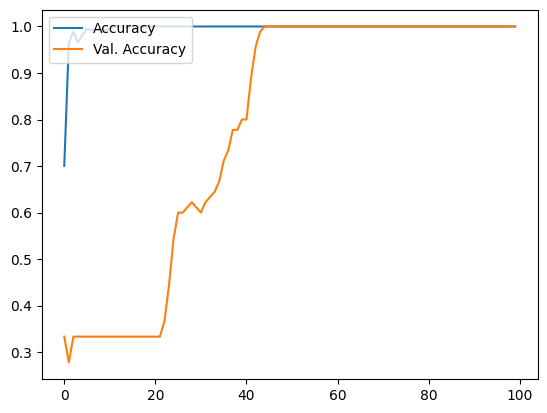

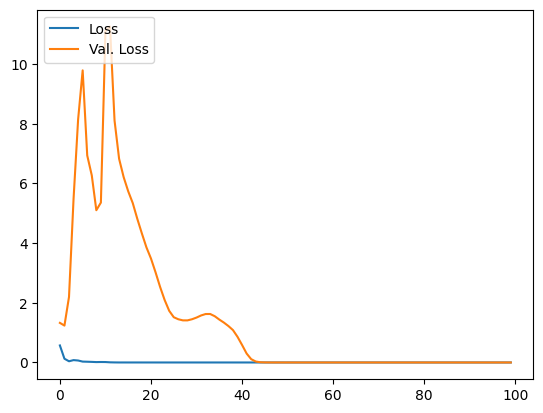

In [ ]:
# grafik akurasi
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val. Accuracy')
plt.legend(loc='upper left')
plt.show()

# grafik error
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val. Loss')
plt.legend(loc='upper left')
plt.show()

In [ ]:
from tensorflow import keras
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import glob
import random

In [ ]:
classes = ['Lexus 430', 
           'MX5 Miata', 
           'Nissan R35']

test_dataset = tf.keras.utils.image_dataset_from_directory(
    '/content/drive/MyDrive/hutweel/data/uji',
    seed=4285938,
    image_size=(img_width, img_height),
    batch_size=32
)

AUTOTUNE = tf.data.AUTOTUNE
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

Found 90 files belonging to 3 classes.


In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/hutweel/model/ModelCheckpoint.epoch54-loss0.00-acc1.00.hdf5')

In [ ]:
import tensorflow as tf

# mengambil data uji secara acak
images = glob.glob('/content/drive/MyDrive/hutweel/data/uji/*/*.jpg', recursive=True)
random.shuffle(images)
images = images[0:80]

img_array = []
for image_path in images:
  img = tf.keras.utils.load_img(image_path, target_size=(128, 128))
  img_array.append(tf.keras.utils.img_to_array(img))

nr = len(images) // 4
nc = 4
fig, axs = plt.subplots(nr, nc, figsize=(20, 120))

for i in range(nr):
  for j in range(nc):
    img = img_array[i * nc + j]
    pred = model.predict(np.expand_dims(img, 0))
    score = tf.nn.softmax(pred[0])
    max = np.argmax(score)

    axs[i, j].set_title("{}: {:.2f}%".format(classes[max], score[max] * 100))
    axs[i, j].imshow(tf.keras.utils.array_to_img(img))

plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

ground_truth = []
for x in test_dataset:
  for y in x[1]:
    ground_truth.append(y.numpy())

print(len(ground_truth))

preds = model.predict(test_dataset)
# preds = np.argmax(preds, axis=1)
preds = np.argmax(tf.nn.softmax(preds), axis=1)
print(preds)
print('Confusion Matrix')
print(confusion_matrix(ground_truth, preds))

90
3/3 [==============================] - 0s 108ms/step
[2 2 1 1 2 1 0 0 0 1 2 2 1 2 0 2 0 2 2 0 0 2 0 0 1 2 0 1 2 1 0 1 0 1 1 1 2
 0 0 2 1 0 2 1 0 0 1 1 2 1 2 0 2 1 1 2 2 0 0 0 2 2 0 0 2 0 1 2 2 0 1 2 1 1
 2 1 0 2 0 1 0 1 0 2 1 1 2 1 1 0]
Confusion Matrix
[[30  0  0]
 [ 0 30  0]
 [ 0  0 30]]
